In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
import trimesh
from trimesh import primitives, transformations
from trimesh.exchange.obj import load_obj
import numpy as np
import math
import matplotlib.pyplot as plt
from datasets import SingleModelData
from models import VNEncoder, VNDecoder, VNAutoEncoder

%load_ext autoreload
%autoreload 2

c:\Users\giaco\anaconda3\envs\giatorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
encoder = VNEncoder(576, 64, use_relu=True)
decoder = VNDecoder(64, 576, use_relu=True)

In [3]:
x = torch.randn((32, 576, 3))

In [4]:
z = encoder(x)

In [5]:
z.shape

torch.Size([32, 64, 3])

In [6]:
z[0][0]

tensor([-0.5025, -0.2981, -0.0547], grad_fn=<SelectBackward0>)

In [7]:
x_ = decoder(z)

In [8]:
x_.shape

torch.Size([32, 576, 3])

In [9]:
dataset = SingleModelData()
loader = DataLoader(dataset, batch_size=64)

In [10]:
data = next(iter(loader))

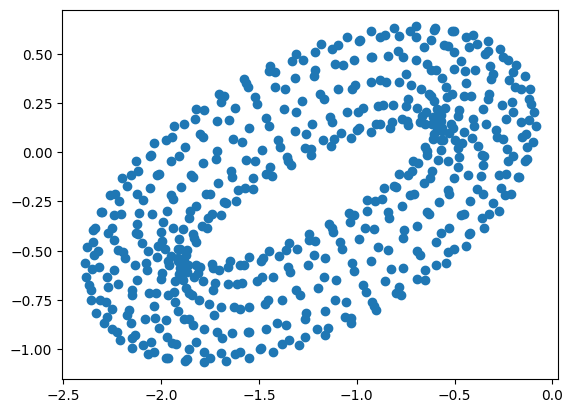

In [11]:
verts = data[13].numpy()
plt.scatter(verts[:,0], verts[:,1])

In [12]:
train_bs = 32
#test_bs = 1000
lr = 1e-4
n_iter = 10000

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset = SingleModelData()
n_verts = dataset.num_verts
train_loader = DataLoader(dataset, batch_size=train_bs,
                    shuffle=False)
train_loader = iter(train_loader)
# test_loader = DataLoader(dataset, batch_size=test_bs,
#                     shuffle=False)

model = VNAutoEncoder(n_verts, use_relu=False)
model.to(device)

opt = Adam(model.parameters(), lr=lr)

for i in range(n_iter):
    
    data = next(train_loader)
    data = data.to(device)
    
    opt.zero_grad()
    
    y_pred, _ = model(data)
    loss = F.mse_loss(data, y_pred)
    print(i, '-', loss.item())
    loss.backward()
    opt.step()

0 - 1.2653367519378662
1 - 1.255271315574646
2 - 1.2453669309616089
3 - 1.234832763671875
4 - 1.2230459451675415
5 - 1.2095848321914673
6 - 1.194148063659668
7 - 1.1764932870864868
8 - 1.1564183235168457
9 - 1.1337592601776123
10 - 1.1083954572677612
11 - 1.0802584886550903
12 - 1.049344778060913
13 - 1.0157326459884644
14 - 0.9796040654182434
15 - 0.9412716627120972
16 - 0.9012057185173035
17 - 0.8600574135780334
18 - 0.8186720013618469
19 - 0.7780749201774597
20 - 0.7394042015075684
21 - 0.7037516236305237
22 - 0.6718805432319641
23 - 0.64387047290802
24 - 0.6188720464706421
25 - 0.595247745513916
26 - 0.5712181329727173
27 - 0.5456690192222595
28 - 0.5185655951499939
29 - 0.49079278111457825
30 - 0.4636630117893219
31 - 0.4383977949619293
32 - 0.41576579213142395
33 - 0.39594268798828125
34 - 0.378583699464798
35 - 0.3630453646183014
36 - 0.3486555516719818
37 - 0.33492836356163025
38 - 0.32166600227355957
39 - 0.3089473843574524
40 - 0.29703289270401
41 - 0.28622573614120483
42 - 0

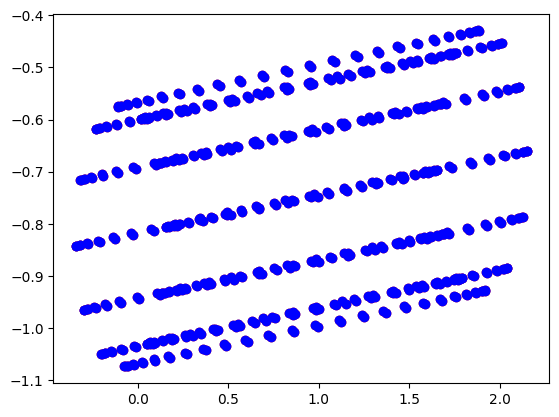

In [14]:
whichsample = 25
verts_pred = y_pred[whichsample].detach().cpu().numpy()
verts_real = data[whichsample].detach().cpu().numpy()
plt.scatter(verts_pred[:,0], verts_pred[:,1], c='red')
plt.scatter(verts_real[:, 0], verts_real[:, 1], c='blue')

#### Test equivariance

In [32]:
with open('data/torus.obj', 'rb') as f:
    obj = load_obj(f)
vertices = obj['vertices']

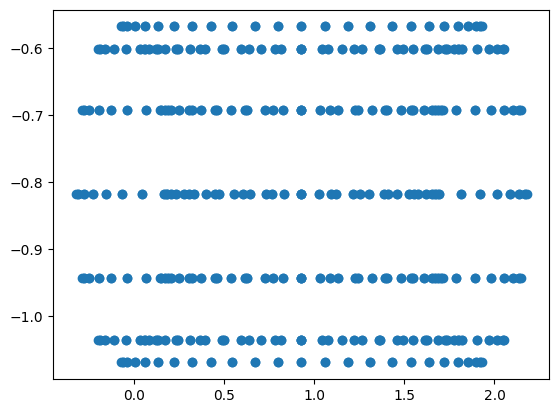

In [33]:
plt.scatter(vertices[:, 0], vertices[:, 1])

In [34]:
angle = math.pi/2
direction = [0, 1, 1]
rot_matrix = transformations.rotation_matrix(angle,
                                             direction,
                                             [0, 0, 0])
transf_vertices = np.column_stack([vertices, 
                            np.ones((len(vertices), 1))])
transf_vertices = transf_vertices @ rot_matrix

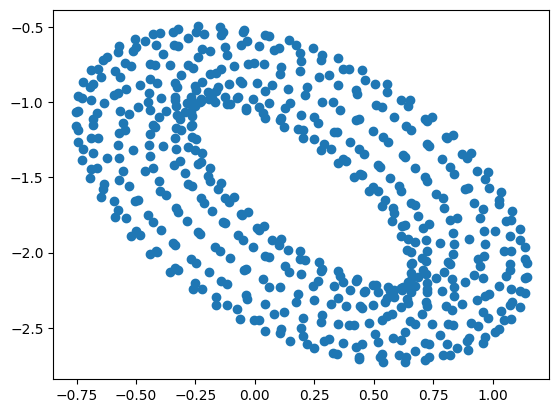

In [31]:
plt.scatter(vertices[:, 0], vertices[:, 1])

In [44]:
in_verts = torch.Tensor(vertices).unsqueeze(0).to(device)
model.eval()
encoder = model.encoder
decoder = model.decoder

In [39]:
z = encoder(in_verts)

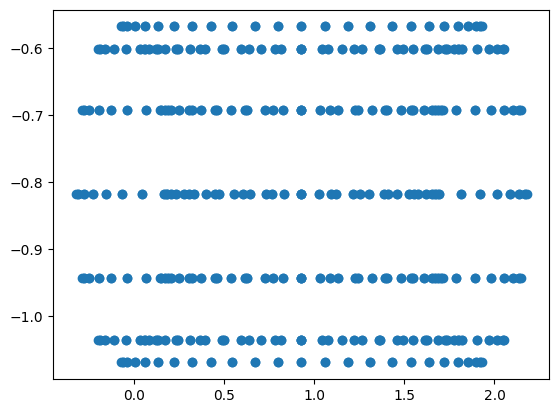

In [42]:
x_pred = decoder(z).detach().cpu().numpy()[0]
plt.scatter(x_pred[:, 0], x_pred[:, 1])

In [50]:
angle = math.pi/2
direction = [0, 1, 1]
rot_matrix = transformations.rotation_matrix(angle,
                                             direction,
                                             [0, 0, 0])
z_transf = z.detach().cpu().numpy()[0]
z_transf = np.column_stack([z_transf, 
                            np.ones((len(z_transf), 1))])
z_transf = z_transf @ rot_matrix
z_transf = torch.Tensor(z_transf[:, :3]).unsqueeze(0).to(device)

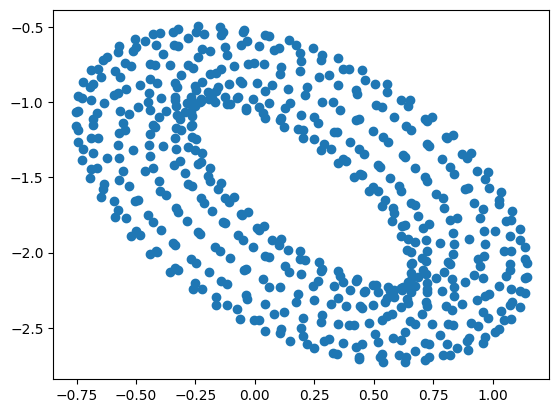

In [52]:
x_tr_pred = decoder(z_transf).detach().cpu().numpy()[0]
plt.scatter(x_tr_pred[:, 0], x_tr_pred[:, 1])

In [ ]:
verts = verts @ rot_matrix

In [ ]:
verts[:,:3]

In [ ]:
plt.scatter(verts[:,0], verts[:,1])

In [ ]:
a = torch.arange(6).reshape(2,3)
b = torch.arange(3)
torch.einsum('ij,j->i', [a,b])

In [ ]:
a = torch.arange(6).reshape(2,3)
b = torch.arange(15).reshape(3, 5)
torch.einsum('ik,kj->ij', [a, b])

In [ ]:
a = torch.arange(6).reshape(2, 3)
b = torch.arange(6,12).reshape(2, 3)
torch.einsum('ij,ij->ij', [a, b])

In [ ]:
a = torch.arange(3)
b = torch.arange(3,7)  # -- a vector of length 4 containing [3, 4, 5, 6]
torch.einsum('i,j->ij', [a, b])

In [ ]:
a = torch.randn(3,2,5)
b = torch.randn(3,5,3)
torch.einsum('ijk,ikl->ijl', [a, b])

In [ ]:
a = torch.randn(2,3,5,7)
b = torch.randn(11,13,3,17,5)
torch.einsum('abcd,efbgc->adefg', [a,b]).shape

In [ ]:
batch_size = 2
N_feat = 16
N_samples = 1

x = torch.randn((batch_size, N_feat, 3, N_samples))
x.shape

In [ ]:
map_to_feat = nn.Linear(N_feat, N_feat*2, bias=False)

In [ ]:
y = map_to_feat(x.transpose(1, -1)).transpose(1, -1)

In [ ]:
x.transpose(1, -1).shape # swap 2nd (features) and last (whatever) dimension

In [ ]:
map_to_feat(x.transpose(1, -1)).shape